IMPORTS AND LIBS


In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
import time
!pip install pyclustering
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.utils import distance_metric, type_metric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 55.9 MB/s eta 0:00:00:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395100 sha256=b385126a24f438b20f9198f4cb7dd76ae31342164ae953d94e23114f7cf8030f
  Stored in directory: /root/.cache/pip/wheels/9f/99/15/e881f46a92690ae77c2e3b255b89ea45d3a867b1b6c2ab3ba9
Successfully built pyclustering


In [2]:
df = pd.read_csv("/kaggle/input/sf-crime/train.csv.zip", on_bad_lines='warn')
df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [3]:
df.shape

(878049, 9)

In [4]:
df.tail()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
878044,2003-01-06 00:15:00,ROBBERY,ROBBERY ON THE STREET WITH A GUN,Monday,TARAVAL,NONE,FARALLONES ST / CAPITOL AV,-122.459033,37.714056
878045,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,INGLESIDE,NONE,600 Block of EDNA ST,-122.447364,37.731948
878046,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,SOUTHERN,NONE,5TH ST / FOLSOM ST,-122.403390,37.780266
878047,2003-01-06 00:01:00,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Monday,SOUTHERN,NONE,TOWNSEND ST / 2ND ST,-122.390531,37.780607
878048,2003-01-06 00:01:00,FORGERY/COUNTERFEITING,"CHECKS, FORGERY (FELONY)",Monday,BAYVIEW,NONE,1800 Block of NEWCOMB AV,-122.394926,37.738212


In [5]:
df.at[df.index[-1], 'X'] =-122.405469
df.at[df.index[-1], 'Y'] =37.79387
df.tail()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
878044,2003-01-06 00:15:00,ROBBERY,ROBBERY ON THE STREET WITH A GUN,Monday,TARAVAL,NONE,FARALLONES ST / CAPITOL AV,-122.459033,37.714056
878045,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,INGLESIDE,NONE,600 Block of EDNA ST,-122.447364,37.731948
878046,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,SOUTHERN,NONE,5TH ST / FOLSOM ST,-122.403390,37.780266
878047,2003-01-06 00:01:00,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Monday,SOUTHERN,NONE,TOWNSEND ST / 2ND ST,-122.390531,37.780607
878048,2003-01-06 00:01:00,FORGERY/COUNTERFEITING,"CHECKS, FORGERY (FELONY)",Monday,BAYVIEW,NONE,1800 Block of NEWCOMB AV,-122.405469,37.793870


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Dates       878049 non-null  object 
 1   Category    878049 non-null  object 
 2   Descript    878049 non-null  object 
 3   DayOfWeek   878049 non-null  object 
 4   PdDistrict  878049 non-null  object 
 5   Resolution  878049 non-null  object 
 6   Address     878049 non-null  object 
 7   X           878049 non-null  float64
 8   Y           878049 non-null  float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB


In [7]:
df['Dates'] = pd.to_datetime(df['Dates'])

In [8]:
df.duplicated().sum()

2323

In [9]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [10]:
df.shape

(875726, 9)

In [11]:
df[df['Address'] == '700 Block of COMMERCIAL ST']

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
15722,2015-02-22 23:00:00,LARCENY/THEFT,PETTY THEFT OF PROPERTY,Sunday,CENTRAL,NONE,700 Block of COMMERCIAL ST,-122.405469,37.793870
25179,2015-01-10 18:22:00,NON-CRIMINAL,"AIDED CASE, INJURED PERSON",Saturday,CENTRAL,NONE,700 Block of COMMERCIAL ST,-122.405469,37.793870
29050,2014-12-24 20:00:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,CENTRAL,NONE,700 Block of COMMERCIAL ST,-122.405469,37.793870
34606,2014-11-26 15:50:00,ASSAULT,BATTERY,Wednesday,CENTRAL,"ARREST, BOOKED",700 Block of COMMERCIAL ST,-122.405491,37.793979
34607,2014-11-26 15:50:00,ASSAULT,WILLFUL CRUELTY TO CHILD,Wednesday,CENTRAL,"ARREST, BOOKED",700 Block of COMMERCIAL ST,-122.405491,37.793979
52666,2014-09-02 21:20:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Tuesday,CENTRAL,NONE,700 Block of COMMERCIAL ST,-122.405469,37.793870
55048,2014-08-21 12:00:00,OTHER OFFENSES,FALSE PERSONATION TO RECEIVE MONEY OR PROPERTY,Thursday,CENTRAL,NONE,700 Block of COMMERCIAL ST,-122.405469,37.793870
115268,2013-10-28 22:30:00,ROBBERY,"ROBBERY ON THE STREET, STRONGARM",Monday,CENTRAL,NONE,700 Block of COMMERCIAL ST,-122.405491,37.793979
151440,2013-05-14 17:25:00,STOLEN PROPERTY,"STOLEN PROPERTY, POSSESSION WITH KNOWLEDGE, RE...",Tuesday,CENTRAL,"ARREST, BOOKED",700 Block of COMMERCIAL ST,-122.405491,37.793979
194816,2012-10-15 08:00:00,DISORDERLY CONDUCT,"DISTURBING THE PEACE, COMMOTION",Monday,CENTRAL,NONE,700 Block of COMMERCIAL ST,-122.405469,37.793870


In [12]:
df.describe()

,Dates,X,Y
count,875726,875726.000000,875726.000000
mean,2009-03-16 09:08:31.826667264,-122.422623,37.771032
min,2003-01-06 00:01:00,-122.513642,37.707879
25%,2006-01-11 01:04:45,-122.432952,37.752427
50%,2009-03-07 16:37:30,-122.416446,37.775421
75%,2012-06-11 11:15:00,-122.406959,37.784380
max,2015-05-13 23:53:00,-120.500000,90.000000
std,NaN,0.030363,0.457497


In [13]:
df.nunique()

Dates         389257
Category          39
Descript         879
DayOfWeek          7
PdDistrict        10
Resolution        17
Address        23228
X              34243
Y              34243
dtype: int64

In [14]:
df["Category"].unique()

array(['WARRANTS', 'OTHER OFFENSES', 'LARCENY/THEFT', 'VEHICLE THEFT',
       'VANDALISM', 'NON-CRIMINAL', 'ROBBERY', 'ASSAULT', 'WEAPON LAWS',
       'BURGLARY', 'SUSPICIOUS OCC', 'DRUNKENNESS',
       'FORGERY/COUNTERFEITING', 'DRUG/NARCOTIC', 'STOLEN PROPERTY',
       'SECONDARY CODES', 'TRESPASS', 'MISSING PERSON', 'FRAUD',
       'KIDNAPPING', 'RUNAWAY', 'DRIVING UNDER THE INFLUENCE',
       'SEX OFFENSES FORCIBLE', 'PROSTITUTION', 'DISORDERLY CONDUCT',
       'ARSON', 'FAMILY OFFENSES', 'LIQUOR LAWS', 'BRIBERY',
       'EMBEZZLEMENT', 'SUICIDE', 'LOITERING',
       'SEX OFFENSES NON FORCIBLE', 'EXTORTION', 'GAMBLING', 'BAD CHECKS',
       'TREA', 'RECOVERED VEHICLE', 'PORNOGRAPHY/OBSCENE MAT'],
      dtype=object)

In [15]:
df["PdDistrict"].unique()

array(['NORTHERN', 'PARK', 'INGLESIDE', 'BAYVIEW', 'RICHMOND', 'CENTRAL',
       'TARAVAL', 'TENDERLOIN', 'MISSION', 'SOUTHERN'], dtype=object)

In [16]:
df["Resolution"].unique()

array(['ARREST, BOOKED', 'NONE', 'ARREST, CITED', 'PSYCHOPATHIC CASE',
       'JUVENILE BOOKED', 'UNFOUNDED', 'EXCEPTIONAL CLEARANCE', 'LOCATED',
       'CLEARED-CONTACT JUVENILE FOR MORE INFO', 'NOT PROSECUTED',
       'JUVENILE DIVERTED', 'COMPLAINANT REFUSES TO PROSECUTE',
       'JUVENILE ADMONISHED', 'JUVENILE CITED',
       'DISTRICT ATTORNEY REFUSES TO PROSECUTE',
       'PROSECUTED BY OUTSIDE AGENCY', 'PROSECUTED FOR LESSER OFFENSE'],
      dtype=object)

In [17]:
# Total number of records for each crime category
g1 = df.groupby("Category").size()
g1

Category
ARSON                            1512
ASSAULT                         76815
BAD CHECKS                        406
BRIBERY                           289
BURGLARY                        36600
DISORDERLY CONDUCT               4313
DRIVING UNDER THE INFLUENCE      2268
DRUG/NARCOTIC                   53919
DRUNKENNESS                      4277
EMBEZZLEMENT                     1164
EXTORTION                         256
FAMILY OFFENSES                   488
FORGERY/COUNTERFEITING          10592
FRAUD                           16637
GAMBLING                          146
KIDNAPPING                       2340
LARCENY/THEFT                  174320
LIQUOR LAWS                      1899
LOITERING                        1207
MISSING PERSON                  25669
NON-CRIMINAL                    91915
OTHER OFFENSES                 125960
PORNOGRAPHY/OBSCENE MAT            22
PROSTITUTION                     7446
RECOVERED VEHICLE                3132
ROBBERY                         22988
RUN

In [18]:
# Total number of crimes per police district.
g2 = df.groupby("PdDistrict").size()
g2

PdDistrict
BAYVIEW        89098
CENTRAL        85267
INGLESIDE      78722
MISSION       119723
NORTHERN      105105
PARK           49161
RICHMOND       45080
SOUTHERN      156528
TARAVAL        65400
TENDERLOIN     81642
dtype: int64

In [19]:
#Number of cases per resolution type
g3 = df.groupby("Resolution").size()
g3

Resolution
ARREST, BOOKED                            206173
ARREST, CITED                              76832
CLEARED-CONTACT JUVENILE FOR MORE INFO       217
COMPLAINANT REFUSES TO PROSECUTE            3969
DISTRICT ATTORNEY REFUSES TO PROSECUTE      3934
EXCEPTIONAL CLEARANCE                       1528
JUVENILE ADMONISHED                         1451
JUVENILE BOOKED                             5564
JUVENILE CITED                              3322
JUVENILE DIVERTED                            355
LOCATED                                    16889
NONE                                      525122
NOT PROSECUTED                              3710
PROSECUTED BY OUTSIDE AGENCY                2503
PROSECUTED FOR LESSER OFFENSE                 51
PSYCHOPATHIC CASE                          14529
UNFOUNDED                                   9577
dtype: int64

In [20]:
#Number of crimes reported at each address.
g4 = df.groupby("Address").size()
g4

Address
0 Block of  HARRISON ST     1
0 Block of 10TH AV          5
0 Block of 10TH ST         49
0 Block of 11TH ST         48
0 Block of 12TH AV          7
                           ..
ZENO PL / FOLSOM ST         3
ZOE ST / BRANNAN ST        10
ZOE ST / BRYANT ST         10
ZOE ST / FREELON ST         4
ZOE ST / WELSH ST           3
Length: 23228, dtype: int64

In [21]:
# Extract relevant numerical features (geographic coordinates)
features = ['X', 'Y']  # Longitude and latitude
X = df[features]

In [22]:
# Step 2: Remove outliers using IQR

x = df['X']
y = df['Y']


Q1_X = df['X'].quantile(0.25)
Q3_X = df['X'].quantile(0.75)
IQR_X = Q3_X - Q1_X

Q1_Y = df['Y'].quantile(0.25)
Q3_Y = df['Y'].quantile(0.75)
IQR_Y = Q3_Y - Q1_Y

lower_bound_X = Q1_X - 1.5 * IQR_X
upper_bound_X = Q3_X + 1.5 * IQR_X

lower_bound_Y = Q1_Y - 1.5 * IQR_Y
upper_bound_Y = Q3_Y + 1.5 * IQR_Y

df_cleaned = df[(df['X'] >= lower_bound_X) & (df['X'] <= upper_bound_X) &
                (df['Y'] >= lower_bound_Y) & (df['Y'] <= upper_bound_Y)]

outliers = df[
    (x < (Q1_X - 1.5 * IQR_X)) |(x > (Q3_X + 1.5 * IQR_X)) |
    (y < (Q1_Y - 1.5 * IQR_Y)) | (y > (Q3_Y + 1.5 * IQR_Y))
]


print("number of Outliers:", len(outliers))
display(outliers)


number of Outliers: 60126


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
8,2015-05-13 23:00:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,RICHMOND,NONE,600 Block of 47TH AV,-122.508194,37.776601
11,2015-05-13 22:30:00,OTHER OFFENSES,MISCELLANEOUS INVESTIGATION,Wednesday,TARAVAL,NONE,0 Block of ESCOLTA WY,-122.487983,37.737667
28,2015-05-13 21:00:00,LARCENY/THEFT,ATTEMPTED THEFT FROM LOCKED VEHICLE,Wednesday,TARAVAL,NONE,19TH AV / SANTIAGO ST,-122.475773,37.744919
29,2015-05-13 20:56:00,OTHER OFFENSES,MISCELLANEOUS INVESTIGATION,Wednesday,TARAVAL,NONE,2000 Block of 41ST AV,-122.499787,37.748518
38,2015-05-13 20:29:00,WEAPON LAWS,SUSPICIOUS PACKAGE,Wednesday,TARAVAL,NONE,1400 Block of HOLLOWAY AV,-122.473182,37.721565
...,...,...,...,...,...,...,...,...,...
877979,2003-01-06 08:13:00,VEHICLE THEFT,"VEHICLE, RECOVERED, MOTORCYCLE",Monday,TARAVAL,"ARREST, CITED",JUNIPERO SERRA BL / HOLLOWAY AV,-122.472322,37.721622
877980,2003-01-06 08:13:00,VEHICLE THEFT,STOLEN MOTORCYCLE,Monday,TARAVAL,"ARREST, CITED",JUNIPERO SERRA BL / HOLLOWAY AV,-122.472322,37.721622
878010,2003-01-06 05:00:00,BURGLARY,"BURGLARY OF APARTMENT HOUSE, FORCIBLE ENTRY",Monday,RICHMOND,NONE,2400 Block of LAKE ST,-122.485700,37.785776
878012,2003-01-06 05:00:00,FRAUD,"FORGERY, CREDIT CARD",Monday,RICHMOND,NONE,2400 Block of LAKE ST,-122.485700,37.785776


In [23]:
# Step 3: Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cleaned[features])

In [24]:
# Step 4: Sample the data
sample_size = 10000
np.random.seed(42)
sample_indices = np.random.choice(X_scaled.shape[0], sample_size, replace=False)
X_sample = X_scaled[sample_indices]

In [25]:
# Step 5: Apply k-Medoids clustering
num_clusters = 10  # Define the number of clusters

# Randomly select initial medoids
initial_medoids = np.random.choice(range(X_sample.shape[0]), num_clusters, replace=False)

# Initialize and run k-Medoids
kmedoids_instance = kmedoids(X_sample, initial_medoids, metric=distance_metric(type_metric.EUCLIDEAN))
kmedoids_instance.process()

# Get clusters and final medoids
clusters = kmedoids_instance.get_clusters()
final_medoids = kmedoids_instance.get_medoids()

print("Clusters:", clusters)
print("Final Medoids:", final_medoids)

Clusters: [[4, 9, 12, 16, 27, 28, 30, 35, 37, 43, 48, 50, 54, 58, 60, 62, 63, 65, 71, 77, 85, 89, 90, 101, 103, 105, 115, 119, 121, 122, 126, 136, 141, 142, 143, 146, 147, 148, 151, 153, 161, 173, 178, 184, 185, 193, 194, 201, 202, 203, 206, 211, 213, 215, 220, 221, 225, 231, 259, 260, 261, 263, 267, 268, 269, 270, 272, 278, 281, 283, 291, 296, 304, 307, 310, 321, 328, 333, 340, 345, 347, 349, 353, 355, 356, 367, 369, 371, 387, 388, 391, 395, 409, 413, 430, 433, 434, 436, 438, 443, 449, 450, 451, 454, 456, 462, 469, 473, 480, 485, 492, 498, 499, 500, 503, 504, 507, 508, 511, 512, 517, 518, 522, 526, 530, 534, 541, 542, 545, 555, 560, 561, 562, 577, 593, 594, 595, 596, 600, 607, 608, 617, 630, 634, 642, 644, 649, 652, 661, 662, 667, 673, 677, 692, 693, 696, 700, 702, 704, 710, 711, 713, 728, 747, 748, 752, 760, 761, 765, 768, 770, 776, 782, 785, 787, 795, 796, 800, 803, 804, 807, 808, 811, 823, 835, 837, 843, 853, 859, 866, 870, 878, 881, 884, 887, 890, 901, 902, 906, 907, 915, 922, 929

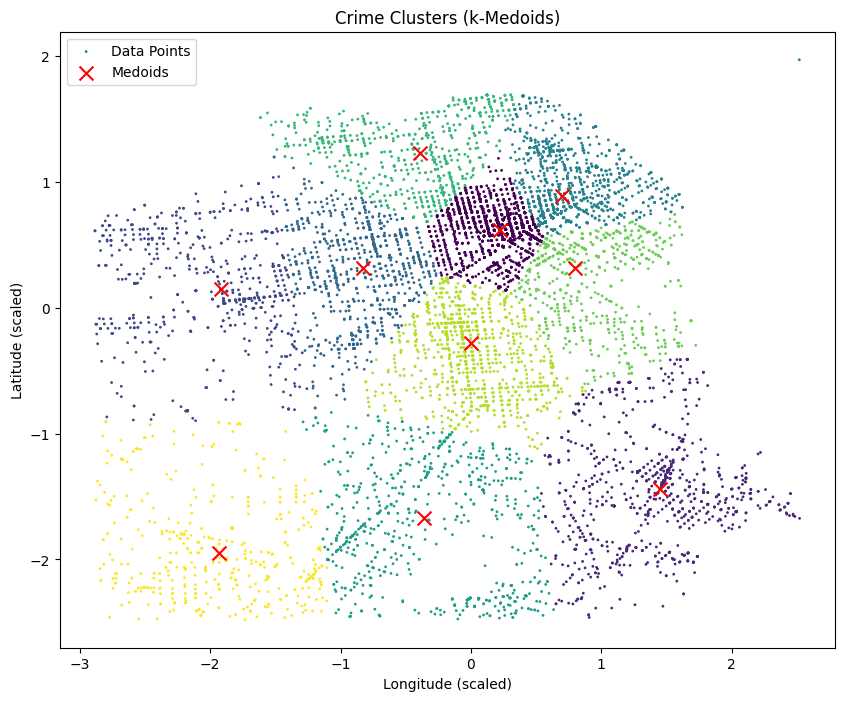

In [26]:
# Step 6: Analyze and visualize the results
# Prepare data for visualization
cluster_labels = np.zeros(X_sample.shape[0])
for cluster_idx, cluster in enumerate(clusters):
    cluster_labels[cluster] = cluster_idx

# Visualize clusters
plt.figure(figsize=(10, 8))
plt.scatter(X_sample[:, 0], X_sample[:, 1], c=cluster_labels, cmap='viridis', s=1, label='Data Points')
plt.scatter(X_sample[final_medoids, 0], X_sample[final_medoids, 1], c='red', marker='x', s=100, label='Medoids')
plt.title("Crime Clusters (k-Medoids)")
plt.xlabel("Longitude (scaled)")
plt.ylabel("Latitude (scaled)")
plt.legend()
plt.show()

In [27]:
dff=df.copy()

In [28]:
#convert date in date time
dff["Datetime"] = pd.to_datetime(dff["Dates"])

In [29]:
# drop unnecessary columns
dff.drop(["Dates"], axis=1, inplace=True)

# dff.rename(columns={"ComputedDay": "DayOfWeek"}, inplace=True)
dff.head()

,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Datetime
0,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015-05-13 23:53:00
1,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015-05-13 23:53:00
2,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015-05-13 23:33:00
3,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015-05-13 23:30:00
4,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015-05-13 23:30:00


In [30]:
dff = df.drop(outliers.index)
print("Data length after removing the Outliers:", len(dff))
display(dff.head())

عدد البيانات بعد حذف الـ Outliers: 815600


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [31]:
dff.nunique()

Dates         372820
Category          39
Descript         874
DayOfWeek          7
PdDistrict        10
Resolution        17
Address        19339
X              28843
Y              28843
dtype: int64

In [32]:
dff["Category"].unique()

array(['WARRANTS', 'OTHER OFFENSES', 'LARCENY/THEFT', 'VEHICLE THEFT',
       'VANDALISM', 'NON-CRIMINAL', 'ROBBERY', 'ASSAULT', 'BURGLARY',
       'SUSPICIOUS OCC', 'DRUNKENNESS', 'WEAPON LAWS',
       'FORGERY/COUNTERFEITING', 'DRUG/NARCOTIC', 'STOLEN PROPERTY',
       'SECONDARY CODES', 'TRESPASS', 'MISSING PERSON', 'FRAUD',
       'KIDNAPPING', 'RUNAWAY', 'SEX OFFENSES FORCIBLE',
       'DISORDERLY CONDUCT', 'ARSON', 'FAMILY OFFENSES', 'PROSTITUTION',
       'DRIVING UNDER THE INFLUENCE', 'LIQUOR LAWS', 'BRIBERY',
       'EMBEZZLEMENT', 'SUICIDE', 'LOITERING',
       'SEX OFFENSES NON FORCIBLE', 'EXTORTION', 'GAMBLING', 'BAD CHECKS',
       'TREA', 'RECOVERED VEHICLE', 'PORNOGRAPHY/OBSCENE MAT'],
      dtype=object)

In [33]:
dff["PdDistrict"].unique()

array(['NORTHERN', 'PARK', 'INGLESIDE', 'BAYVIEW', 'CENTRAL',
       'TENDERLOIN', 'MISSION', 'SOUTHERN', 'TARAVAL', 'RICHMOND'],
      dtype=object)

In [34]:
dff["Resolution"].unique()

array(['ARREST, BOOKED', 'NONE', 'ARREST, CITED', 'PSYCHOPATHIC CASE',
       'JUVENILE BOOKED', 'UNFOUNDED', 'EXCEPTIONAL CLEARANCE', 'LOCATED',
       'CLEARED-CONTACT JUVENILE FOR MORE INFO', 'NOT PROSECUTED',
       'JUVENILE DIVERTED', 'COMPLAINANT REFUSES TO PROSECUTE',
       'JUVENILE ADMONISHED', 'JUVENILE CITED',
       'DISTRICT ATTORNEY REFUSES TO PROSECUTE',
       'PROSECUTED BY OUTSIDE AGENCY', 'PROSECUTED FOR LESSER OFFENSE'],
      dtype=object)

In [35]:
# Total number of records for each crime category
g1 = dff.groupby("Category").size()
g1

Category
ARSON                            1384
ASSAULT                         72041
BAD CHECKS                        377
BRIBERY                           273
BURGLARY                        33285
DISORDERLY CONDUCT               4159
DRIVING UNDER THE INFLUENCE      1990
DRUG/NARCOTIC                   52800
DRUNKENNESS                      4040
EMBEZZLEMENT                     1080
EXTORTION                         219
FAMILY OFFENSES                   453
FORGERY/COUNTERFEITING           9578
FRAUD                           15098
GAMBLING                          137
KIDNAPPING                       2169
LARCENY/THEFT                  162588
LIQUOR LAWS                      1780
LOITERING                        1186
MISSING PERSON                  23807
NON-CRIMINAL                    84787
OTHER OFFENSES                 118246
PORNOGRAPHY/OBSCENE MAT            19
PROSTITUTION                     7355
RECOVERED VEHICLE                2909
ROBBERY                         21902
RUN

In [36]:
# Total number of crimes per police district.
g2 = dff.groupby("PdDistrict").size()
g2

PdDistrict
BAYVIEW        89022
CENTRAL        85262
INGLESIDE      78718
MISSION       119713
NORTHERN      104978
PARK           49117
RICHMOND       26534
SOUTHERN      154895
TARAVAL        25734
TENDERLOIN     81627
dtype: int64

In [37]:
#Number of cases per resolution type
g3 = dff.groupby("Resolution").size()
g3

Resolution
ARREST, BOOKED                            198490
ARREST, CITED                              72940
CLEARED-CONTACT JUVENILE FOR MORE INFO       200
COMPLAINANT REFUSES TO PROSECUTE            3657
DISTRICT ATTORNEY REFUSES TO PROSECUTE      3651
EXCEPTIONAL CLEARANCE                       1341
JUVENILE ADMONISHED                         1218
JUVENILE BOOKED                             5130
JUVENILE CITED                              2842
JUVENILE DIVERTED                            339
LOCATED                                    15650
NONE                                      482280
NOT PROSECUTED                              3356
PROSECUTED BY OUTSIDE AGENCY                2240
PROSECUTED FOR LESSER OFFENSE                 45
PSYCHOPATHIC CASE                          13475
UNFOUNDED                                   8746
dtype: int64

In [38]:
#Number of crimes reported at each address.
g4 = dff.groupby("Address").size()
g4

Address
0 Block of  HARRISON ST     1
0 Block of 10TH AV          5
0 Block of 10TH ST         49
0 Block of 11TH ST         48
0 Block of 12TH AV          7
                           ..
ZENO PL / FOLSOM ST         3
ZOE ST / BRANNAN ST        10
ZOE ST / BRYANT ST         10
ZOE ST / FREELON ST         4
ZOE ST / WELSH ST           3
Length: 19339, dtype: int64

In [39]:
# Dates can be casted from object into datetime or numbers
dff.Dates = pd.to_datetime(dff.Dates)

first_date = dff.Dates.min()
last_date = dff.Dates.max()


print(f"  First Date of Crime: {first_date}")
print(f"  Last Date of Crime: {last_date}")
print(f"  Total Years of Crime: {(last_date-first_date).days // 365}")

  First Date of Crime: 2003-01-06 00:01:00
  Last Date of Crime: 2015-05-13 23:53:00
  Total Years of Crime: 12


In [40]:
dff['Dates'] = pd.to_datetime(df['Dates'])


dff['Year'] = df['Dates'].dt.year

crimes_per_year = dff['Year'].value_counts().sort_index()

print(crimes_per_year)

Year
2003    68749
2004    67817
2005    65492
2006    65126
2007    63488
2008    65136
2009    64288
2010    62057
2011    61919
2012    66542
2013    70305
2014    69298
2015    25383
Name: count, dtype: int64


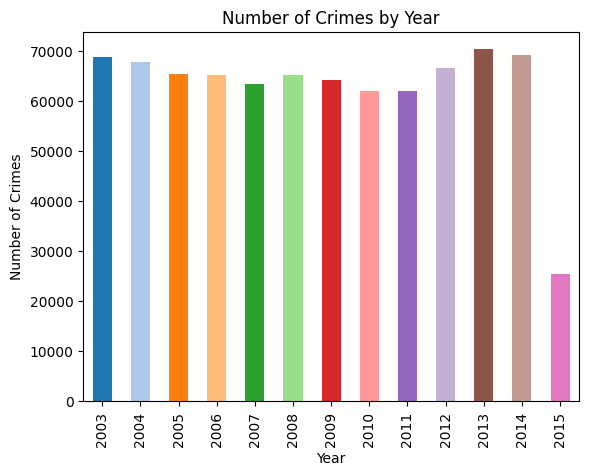

In [41]:
colors = plt.cm.tab20.colors

crimes_per_year.plot(kind='bar',
                     color=colors[:len(crimes_per_year)],
                     title='Number of Crimes by Year')

plt.xlabel('Year')
plt.ylabel('Number of Crimes')
plt.show()

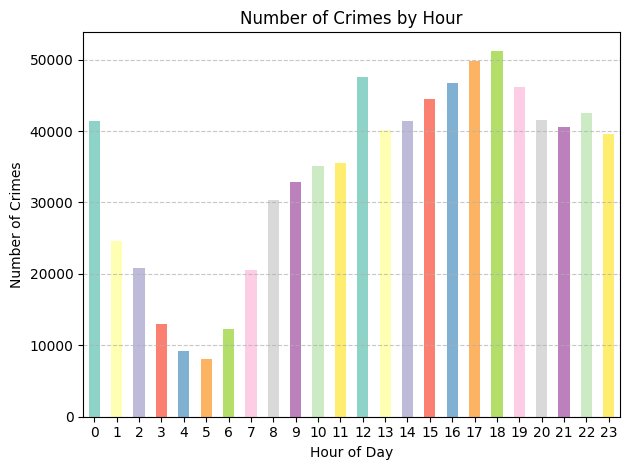

In [42]:
dff['Dates'] = pd.to_datetime(df['Dates'])


dff['Hour'] = dff['Dates'].dt.hour

crimes_per_hour = dff['Hour'].value_counts().sort_index()

colors = plt.cm.Set3.colors

crimes_per_hour.plot(kind='bar',
                     color=colors[:len(crimes_per_hour)],
                     title='Number of Crimes by Hour')

plt.xlabel('Hour of Day')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

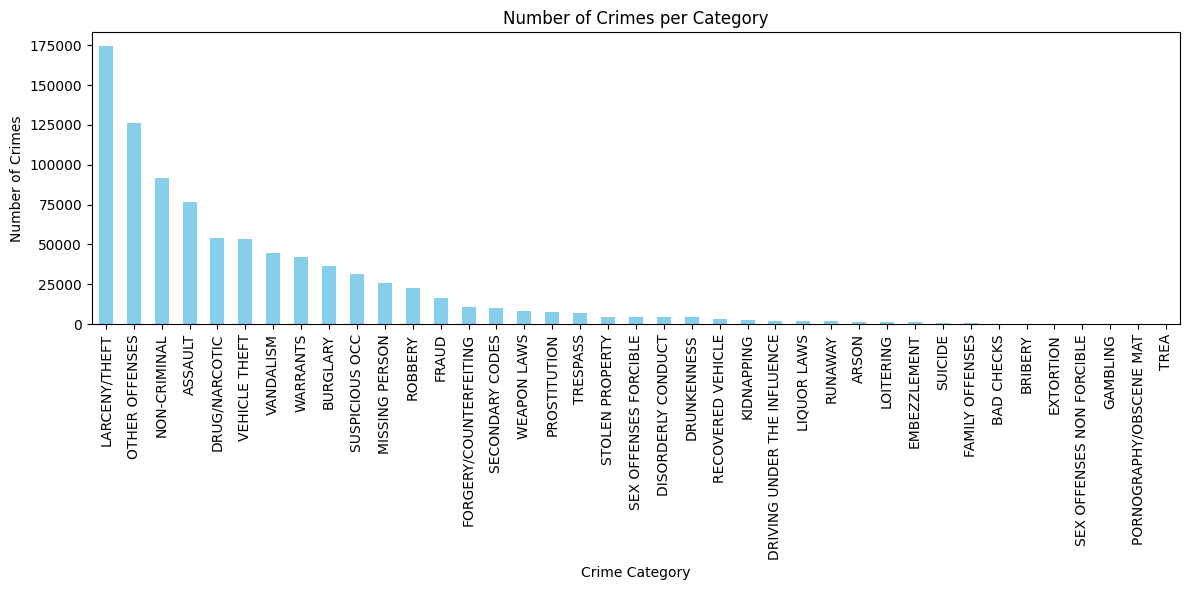

In [43]:
# 1. Bar Chart - Number of Crimes per Category
plt.figure(figsize=(12,6))
df['Category'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Number of Crimes per Category')
plt.xlabel('Crime Category')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

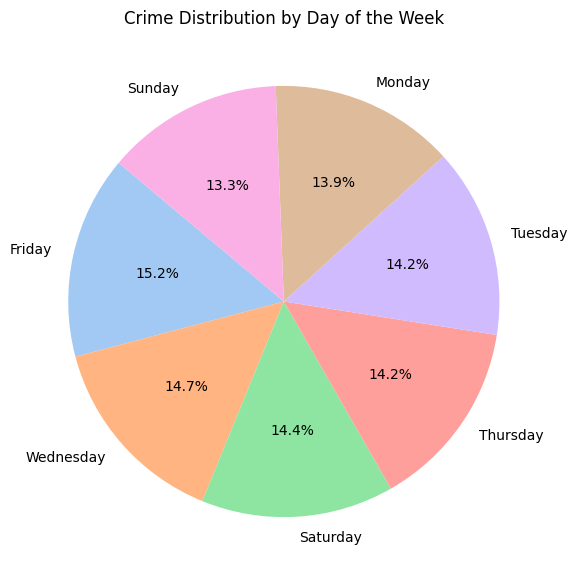

In [44]:
# 2. Pie Chart - Crime Distribution by Day of the Week
day_counts = df['DayOfWeek'].value_counts()
plt.figure(figsize=(7,7))
plt.pie(day_counts, labels=day_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Crime Distribution by Day of the Week')
plt.show()

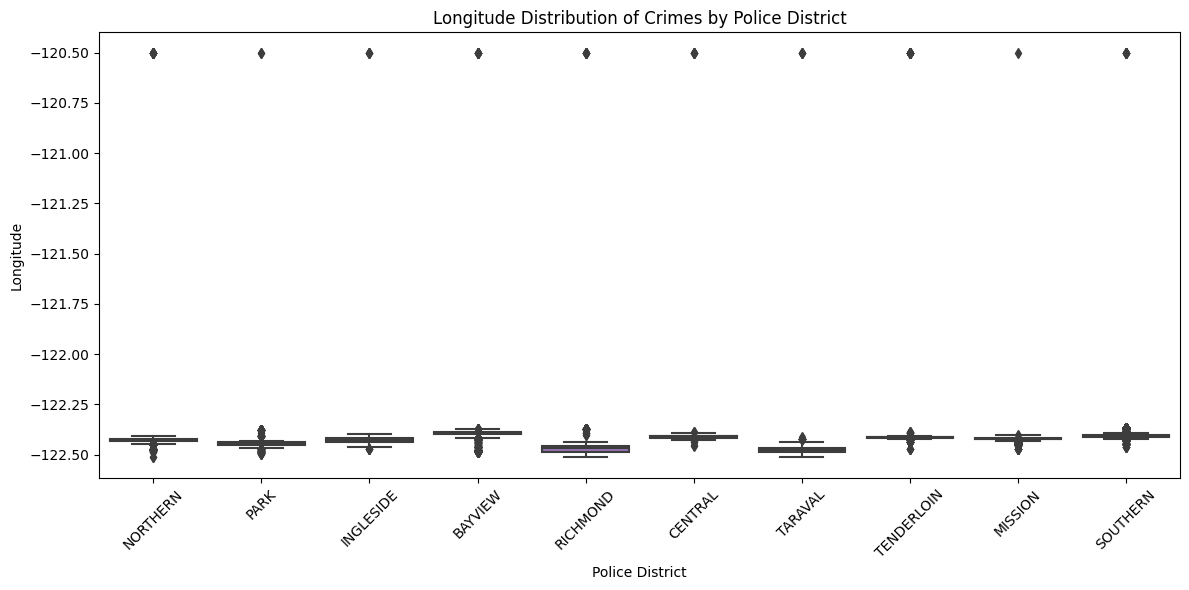

In [45]:
# 3. Box Plot - Longitude Distribution by Police District
plt.figure(figsize=(12,6))
sns.boxplot(x='PdDistrict', y='X', data=df)
plt.title('Longitude Distribution of Crimes by Police District')
plt.xlabel('Police District')
plt.ylabel('Longitude')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

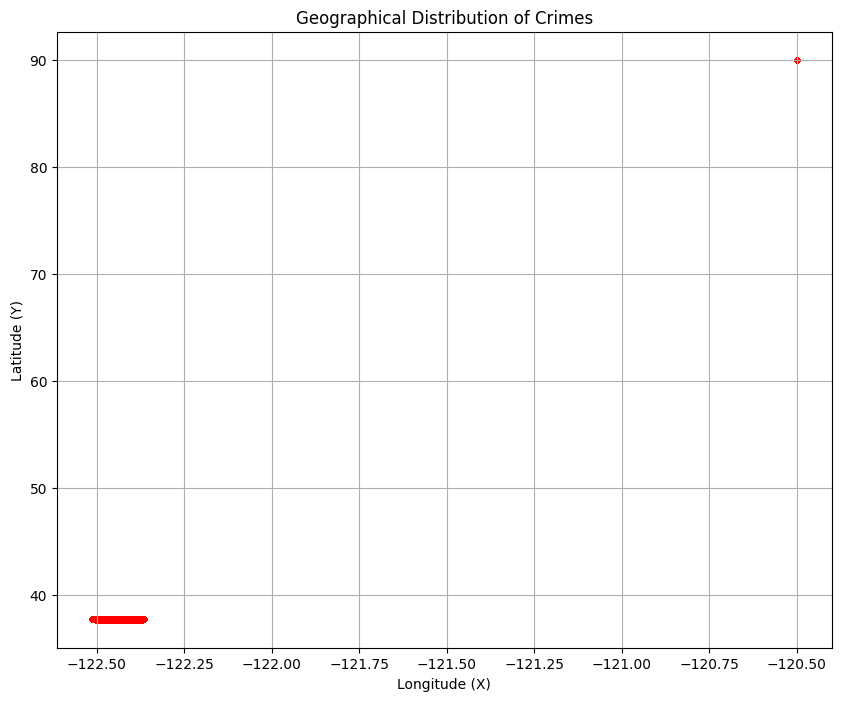

In [46]:
# 4. Scatter Plot - Geographical Crime Locations
plt.figure(figsize=(10,8))
plt.scatter(df['X'], df['Y'], alpha=0.2, s=10, color='red')
plt.title('Geographical Distribution of Crimes')
plt.xlabel('Longitude (X)')
plt.ylabel('Latitude (Y)')
plt.grid(True)
plt.show()

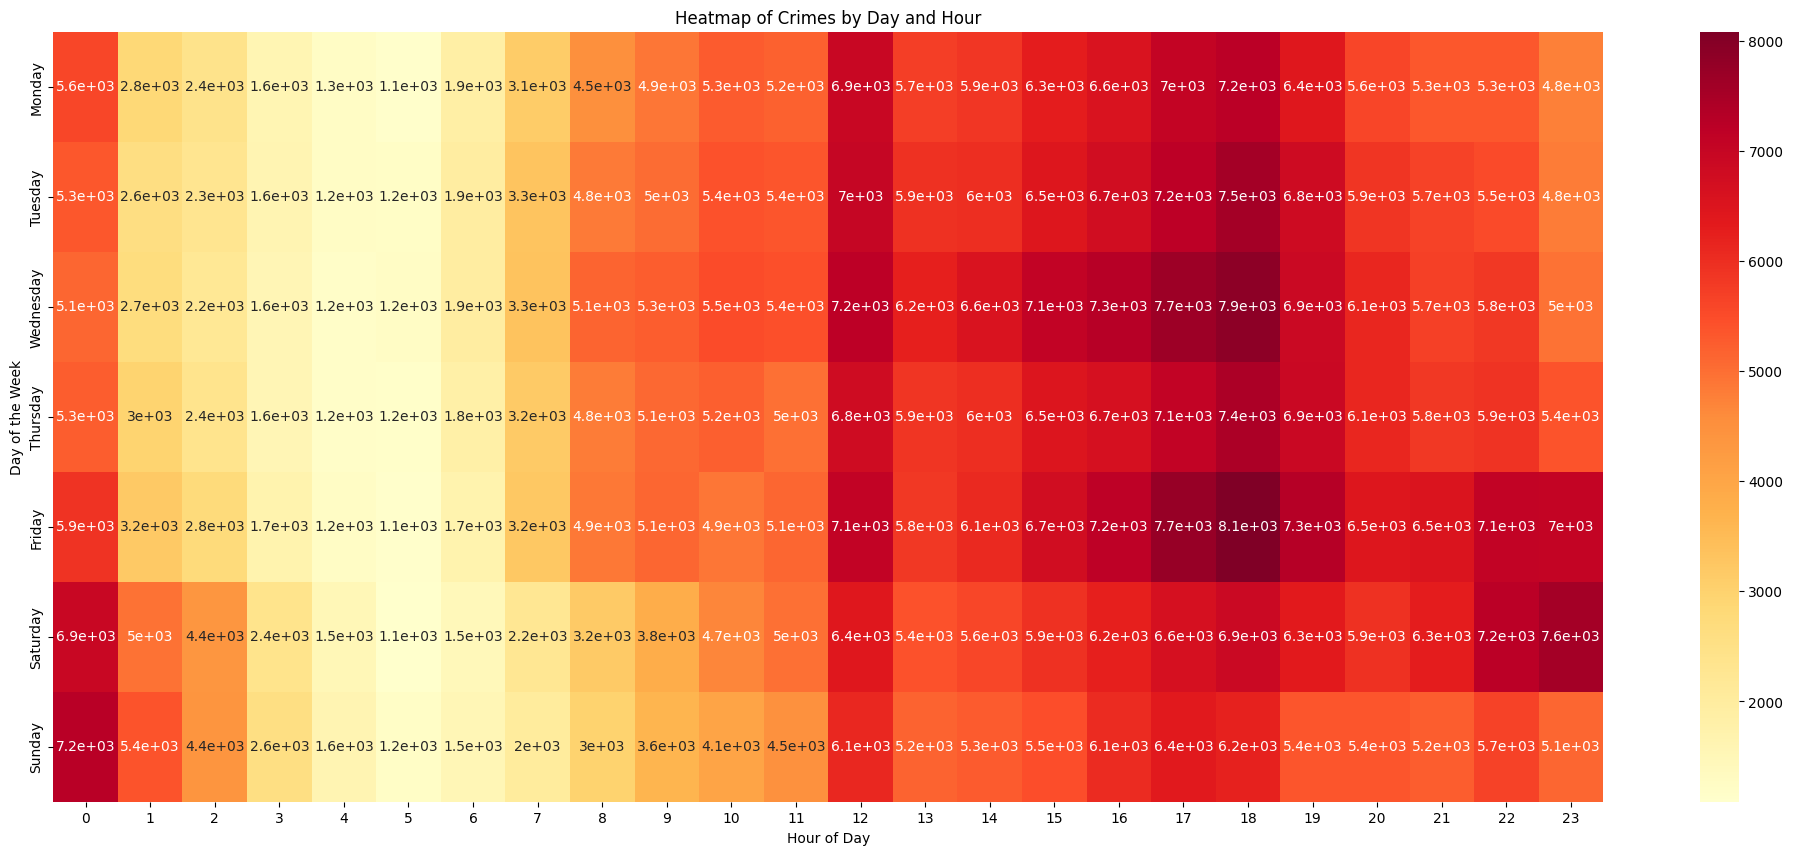

In [47]:
# 5. Heatmap - Crime Distribution by Day and Hour
dff["Datetime"] = pd.to_datetime(dff["Dates"])
dff.loc[: ,'Hour'] = dff['Datetime'].dt.hour
heat_data = pd.crosstab(dff['DayOfWeek'], dff['Hour'])
# Reorder days of the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heat_data = heat_data.reindex(days_order)
plt.figure(figsize=(25,10))
sns.heatmap(heat_data ,annot=True,cmap='YlOrRd')
plt.title('Heatmap of Crimes by Day and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day of the Week')
plt.show()

In [48]:
for data in [dff]:
    data['Dates'] = pd.to_datetime(data['Dates'])
    data['Hour'] = data['Dates'].dt.hour
    data['Month'] = data['Dates'].dt.month
    data['Year'] = data['Dates'].dt.year


le_day = LabelEncoder()
le_district = LabelEncoder()
le_category = LabelEncoder()

dff['DayOfWeek'] = le_day.fit_transform(dff['DayOfWeek'])
dff['PdDistrict'] = le_district.fit_transform(dff['PdDistrict'])
dff['Category'] = le_category.fit_transform(dff['Category'])


In [49]:
from sklearn.model_selection import train_test_split
feature_cols = ['DayOfWeek', 'PdDistrict', 'X', 'Y', 'Hour', 'Month', 'Year']
X = dff[feature_cols]
y = dff['Category']
vectorizer = TfidfVectorizer(max_features=100)
desc_features = vectorizer.fit_transform(dff['Descript']).toarray()


X = np.hstack((X, desc_features))


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
model = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, n_estimators=200, random_state=42)

In [51]:
y_val_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_val_pred)
print(f" Accuracy: {accuracy:.2f}")

 Accuracy: 0.91


In [52]:
# Reduce the number of trees and depth
# Optimized Random Forest implementation
model = RandomForestClassifier(
    n_estimators=30,
    max_depth=8,
    min_samples_split=50,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42,
    verbose=1
)
print("Starting model training...")
start_time = time.time()

model.fit(X_train, y_train)

end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds")

# Evaluation
y_val_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred, average='weighted')
recall = recall_score(y_val, y_val_pred, average='weighted')
f1 = f1_score(y_val, y_val_pred, average='weighted')

print(f"\nAccuracy: {accuracy:f}")
print(f"Precision: {precision:f}")
print(f"Recall: {recall:f}")
print(f"F1 Score: {f1:f}")

Starting model training...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   15.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


Training completed in 15.95 seconds


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    1.0s finished
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Accuracy: 0.805714
Precision: 0.796827
Recall: 0.805714
F1 Score: 0.773558


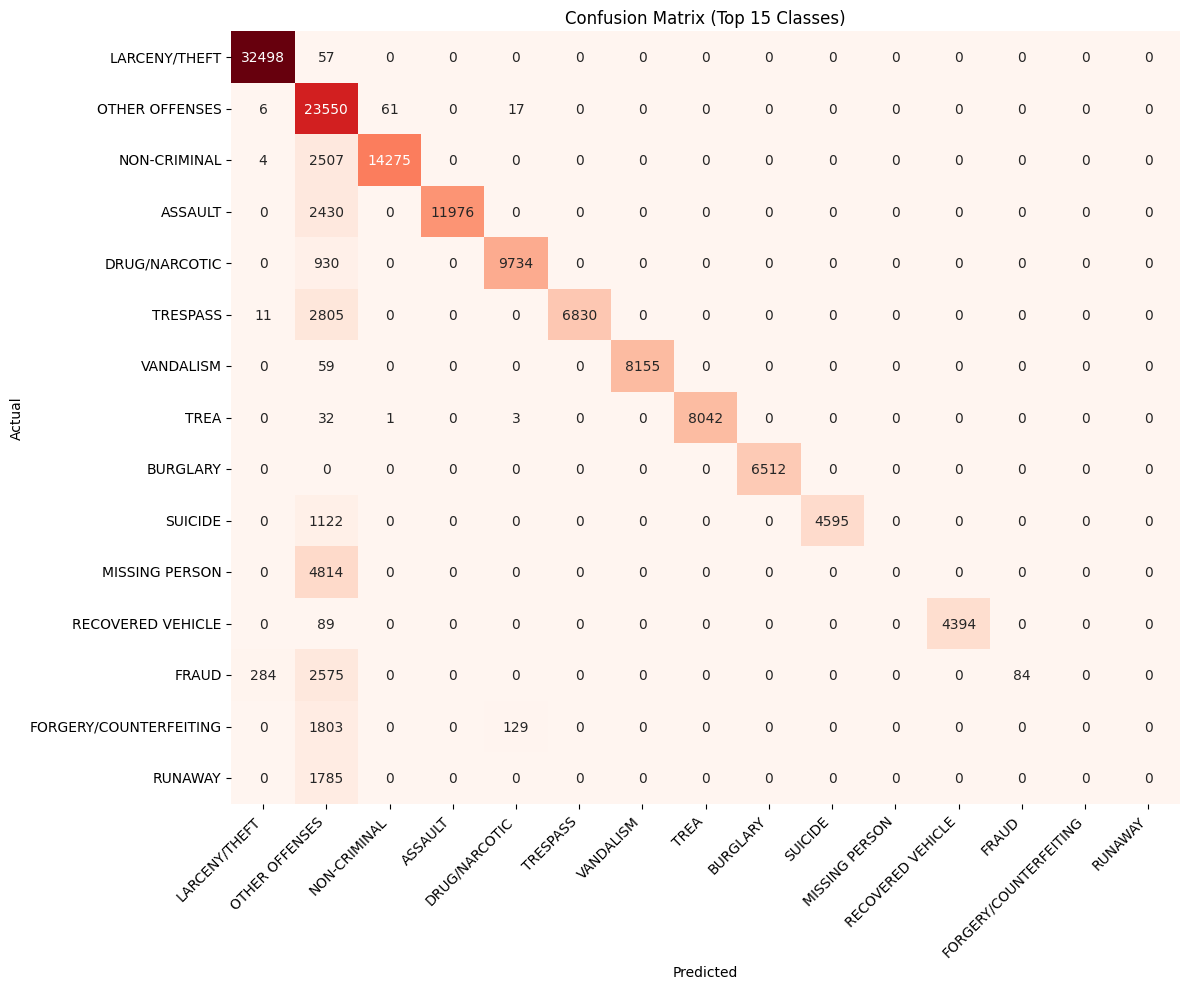

In [53]:
# 4. Confusion matrix visualization
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_val, y_val_pred)

# show only top N classes
top_n = 15  # Adjust based on your needs
if len(le_category.classes_) > top_n:
    # Get indices of top N most frequent classes
    class_counts = np.sum(cm, axis=1)
    top_classes = np.argsort(-class_counts)[:top_n]
    cm = cm[top_classes][:, top_classes]
    class_names = le_category.classes_[top_classes]
else:
    class_names = le_category.classes_

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False,
            xticklabels=class_names,
            yticklabels=class_names)
plt.title(f'Confusion Matrix (Top {len(class_names)} Classes)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()